The following code just sets up this notebook environment. Just run it once and then ignore it.

In [1]:
# Execute this cell once to setup the notebook environment, then ignore it

# set the path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# load the notebook's style sheet
from IPython.core.display import HTML
css_file = 'style.css'
HTML(open(css_file, "r").read())

# embed plots
%matplotlib inline

from regression.toolkit import generate_linear_data, plot, print_residuals, np
from regression.toolkit import huber, SGDRegressor, generate_quadratic_data, generate_unscaled_data

# Introduction to Linear Regression

Let's take a look at the following this dataset.

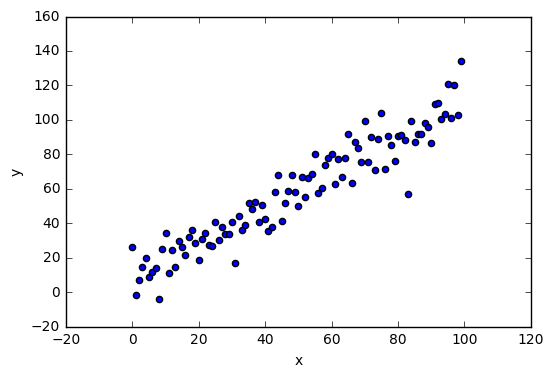

In [2]:
x, y = generate_linear_data(slope=1, intercept=10, noise_std=10)
plot(x, y)

If you had to represent all these data points in one single line, how would the line would look like?
Well, that's what a linear regression does: It finds the line whose distance to all the datapoints is minimum. These distace are called residuals.

Concretelly, in the above dataset a linear regression is a linear function of the type: 

$$f(x) = \theta_0 + \theta_1 \cdot x$$

where $\theta_0$ and $\theta_1$ are the coefficients that set the position and slope of the linear function. In the general case a regresion has n coefficients:

$$f(x) = \theta_0 + \theta_1 \cdot x_1 + \theta_2 \cdot x_2 + ... + \theta_n \cdot x_n = \theta_0 + \sum_{i=1}^n\theta_i \cdot x_i$$

However, in order to make this explanation easier, for now we will focus on a regression with two coeficients only: $\theta_0$ and $\theta_1$.

Now the question is, how do we find the $\theta_0$ and $\theta_1$ that minimize the residuals? One option is to try different values for $\theta_0$ and $\theta_1$ until we find the one that minimizes these residuals.

Well, let's to do that.

In the below box, find the values of $\theta_0$ and $\theta_1$ that minimize the residuals. Keep in mind that when the position of the line is too high, then $\theta_0$ should be lower, and when the slope is too high, then $\theta_1$ should be lower. This also applies in the oposite scenario.

As an example, we start with $\theta_0 = 60$ and $\theta_1 = 0.08$.

(Keep in mind that in our Python implementation below x is a vector that has the example datapoints and predictions is the vector with the predictions. The regression gives a prediction for each element in x and stores it in predictions using the same order as in x.)

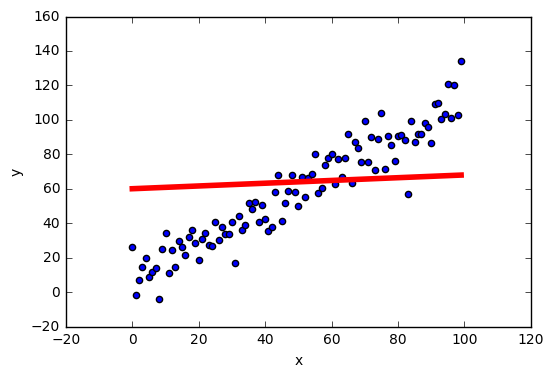

Summation of residuals is 272,376.72


In [3]:
theta0 = 60
theta1 = 0.08

predictions = theta0 + theta1*x
plot(x, y, predictions=predictions)
print_residuals(y, predictions)

It turns out that there is no need to randomly try different values. Let's say that we start with random values $\theta_0$ and $\theta_1$ and that we somehow we can learn if these values need to increase or decrease, and what should be the magnitude of that increase or decrease. Then, after we update these values, we do that again. This goes on until $\theta_0$ and $\theta_1$ are the coefficients that minimize the distance between the datapoints and our line (i.e. the optimal coefficients).

In general this procedure is called an algorithm. In particular this algorithm is called gradient descent.

Before we dive into gradient descent we need to define what are we trying to minimize here.


## Loss Function

In our example, we were trying to minimize the residuals, i.e. distances between all datapoints and our line, and that is a function of the parameters $\theta_0$ and $\theta_1$. We call that function $J(\theta_0, \theta_1)$.

Does that makes sense? think about it... when we updated $\theta_0$ and $\theta_1$ the distance between the datapoints and the line was modified. It bacame smaller at the beggining until we missed the optimum values for $\theta_0$ and $\theta_1$ and then it became larger again. That is us poking with $J(\theta_0, \theta_1)$ by testing different values of $\theta_0$ and $\theta_1$. We were trying to find the optimal (minimum) value.

In our example, $J(\theta_0, \theta_1)$ was defined as the summation of the residuals, which is equal to:

$$J(\theta_0, \theta_1) = |y^{(1)} - f(x^{(1)})| + |y^{(2)} - f(x^{(2)})| +...+ |y^{(n)} - f(x^{(n)})|$$

where $y^{(i)}$ is our target for $x^{(i)}$ $\forall i$ and $n$ is the number of datapoints in the training set. If we expand $f(x)$ we get:

$$J(\theta_0, \theta_1) = |y^{(1)} - (\theta_0 + \theta_1 \cdot x_1^{(1)})| + |y^{(2)} - (\theta_0 + \theta_1 \cdot x_1^{(2)})| +...+ |y^{(n)} - (\theta_0 + \theta_1 \cdot x_1^{(n)})|$$

and since we are doing a lot of adding, let's introduce summations:

$$J(\theta_0, \theta_1) = \sum_{i=1}^n|y^{(i)} - (\theta_0 + \theta_1 \cdot x_1^{(i)})|$$


### General case

We have only seen the case where each of our examples have a single feature, i.e. each example is represented by a number. For example, we may want to predict the price of a house given its size. Since the size of the house can be represented by a single number (its area), this is a one feature regression.

However, we can use more features. What if we wanted to predict the house price given its size and its distance to the downtown? That would make our x become a matrix X (note the capital) with two columns where each example is a row and one column is the size of the house and the other column is the distance to downtown.

In the general case with n features our loss function becomes:

$$J(\theta) = \sum_{i=1}^n|y^{(i)} - x^{(i)} \cdot \theta|$$

Where $\theta$ is a vector with coefficients $\theta_0, \theta_1, ...,\theta_n$, and $x^{(i)}$ is a row in the matrix X. 

**Challenge**: For the above equation to make sense we need to append a column of ones to the left of matrix X. Why? Write your answer in the box below:

**Answer:**

This is the loss function of a linear regression that minimizes the residuals. This function is called **Least Absolute Loss** and when minimized gives the parameters $\theta_0$ and $\theta_1$ that create a **Least Absolute Regression**.

However, classic linear regression assumes that the residuals are normaly distributed. This means the loss function is not the Least Absolute Loss, but the **Least Squared Loss**, which is the sum of the squared residuals:

$$J(\theta_0, \theta_1) = \sum_{i=1}^n(y_i - (\theta_0 + \theta_1 \cdot x_1))^2$$

Minimizing the **Least Squared Error** gives us a **Least Squared Regression**. Let's see how the Least Squared Error function looks in our dataset when setting $\theta_0=0$ and using $\theta_1$ as our only independent variable.

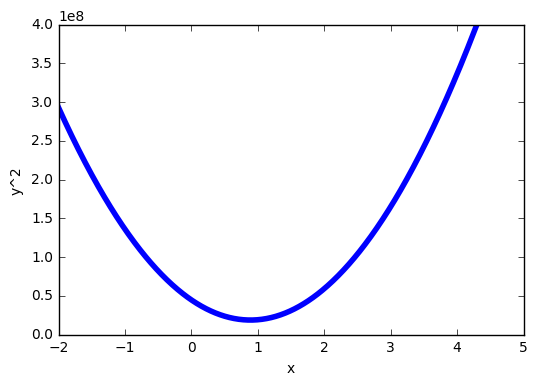

In [4]:
theta0 = 0
theta1 = np.arange(-2, 4.3, 0.01)
squared_residuals = []
for t in theta1:
    predictions = theta0 + t * x
    squared_residuals.append(np.sum(np.square(y - predictions)))
plot(theta1, squared_residuals, y_label='y^2', line=True)

**Challenge**: How would you prove that the Lease Squared Loss is the cost function when residuals are normally distributed? Write your answer below.

**Answer:**

Machine Learning is mostly about modeling a dataset by creating a convex error function and minimizing it.

Since the Least Squares Loss uses the squares of the residuals, it penalizes heavily on large residuals, and not so much on small residuals.

Another popular loss function used in regression is the **Huber loss**, which doesn't penalize outliers as heavily as the Least Squares loss.

\begin{align}
J_{huber}(\theta_0, \theta_1) = \left\{ \begin{array}{cl}
\frac{1}{2} \left[y-f(x)\right]^2 & \text{for }|y-f(x)| \le \delta, \\
\delta \left(|y-f(x)|-\delta/2\right) & \text{otherwise.}
\end{array}\right.
\end{align}

The Huber loss is basicaly a mix between the two loss functions we have seen so far: a Least Squares Loss when the residuals are small and an Absolute Loss when the residuals are large. $\delta$ is the threshold that defines when a residual is small or large. Let's see how the Huber Loss looks like in our dataset: 

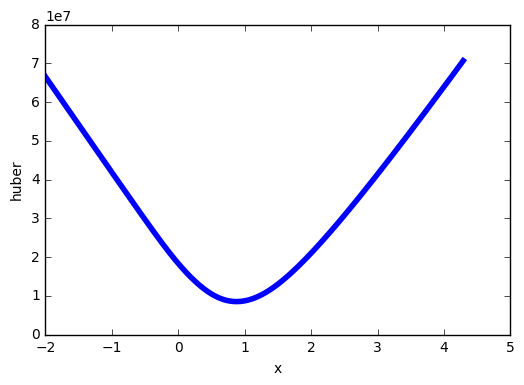

In [5]:
delta = 50
theta0 = 0
theta1 = np.arange(-2, 4.3, 0.01)
huber_residuals = []
for t in theta1:
    predictions = theta0 + t * x
    huber_residuals.append(np.sum(huber(y - predictions, delta)))
plot(theta1, huber_residuals, y_label='huber', line=True)

**Challenge**: The Huber Loss is very usefull when there are outliers in the dataset. Why? Write your answer in the box below.

**Answer:**

## Gradient descent

Now that we understand loss functions, we can look into how to minimize them. Gradient descent is an algorithm that iterates (i.e. "walks") thru a functions until it reaches a minimum value. The algorithm starts with a solution located at a random point on the loss function $J(\theta)$ and does the following:

1) calculate the slope of $J(\theta)$

2) update the current solution by moving it over $J(\theta)$ in the oposite direction of the slope.

The algorithm does 1) and 2) until $J(\theta)$ stops changing (in practice this means $J(\theta)$ changes very little).

We won't implement gradient descent in this class, but it's good that you have an intuition of how this optimization algorithm works.

**Challenge**: would gradient descent find the minimum value in the function below? Write your answer in the box.

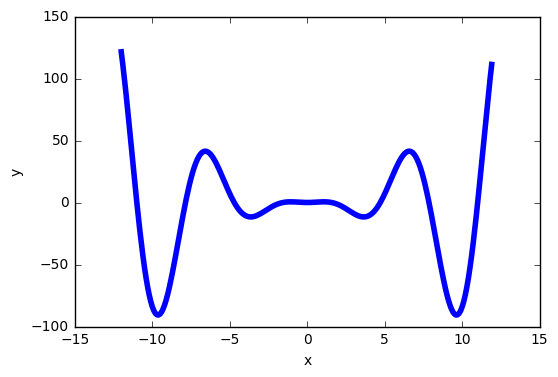

In [6]:
x_ = np.arange(-12, 12, 0.1)
plot(x_, np.multiply(np.cos(x_), np.square(x_)), line=True)

**Answer:**

## Implementing a linear regression machine learning algorithm using scikit learn

scikit learn is a cool Python package. It lets us implement complex algortithms without dealing with the low level implementation details like gradient descent. However we need to know how it works under the hoods so we can tune our algorithms wisely if they don't perform well.

The main scikit learn class we will use for regression is called SGDRegressor. You can check the full API [here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html), but the important bits are:

SDGRegresor() returns an object that is an untrained regression. This means that the regression hasn't been optimized yet so it doesn't have valid coeficients. Let's save such a regression in variable model:

In [7]:
model = SGDRegressor(loss='squared_loss',  n_iter=10, eta0=0.0001)

The parameters of the model are:

* loss is the loss function to use. In this class we will only use squared_loss and huber.
* n_iter is the number of times the algorithm with iterate thru the dataset. Usually the more the better, but there is an acuracy vs. running time tradeoff.
* eta0 is the learning rate or step size. The smaller the step size the more likely the algorithm will converge, but its convergence will take longer.

In order to find the optimum parameters we need to train our regression model. We do that the following way:

In [8]:
model.fit(x, y)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.0001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=10, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

Now our variable model has a trained model object that has valid coefficients. In order to use these coeficients to make a prediction we do the following:

In [9]:
predictions = model.predict(x)

The variable predictions now has our, well, predictions. Let's plot our predictions:

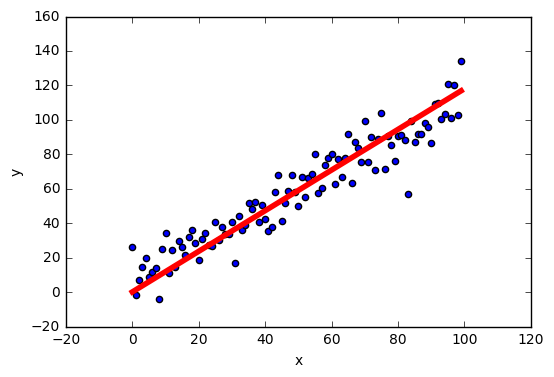

In [10]:
plot(x, y, predictions=predictions)

See what happened? We solved the initial problem of findinf the right line without having to test several coefficients by hand. SGDRegressor took care of it. The only things we had to test were the loss function (loss), the number of iterations (n_iter) and the learning rate (eta0).

## Outlier linear data

The folowing dataset has outliers.

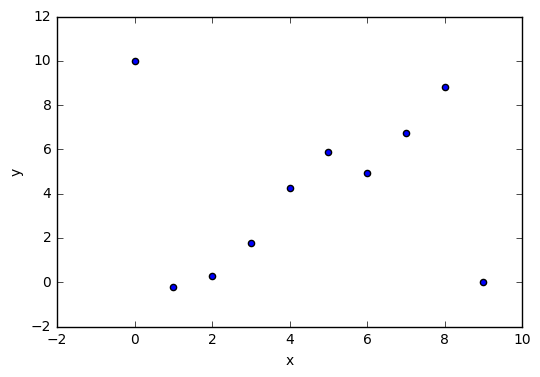

In [11]:
x, y = generate_linear_data(slope=1, intercept=0, noise_std=1, max_x=10)
y[0] = 10
y[y.shape[0]-1] = 0
plot(x, y)

Use SGDRegressor to make a least squares regression on this data:

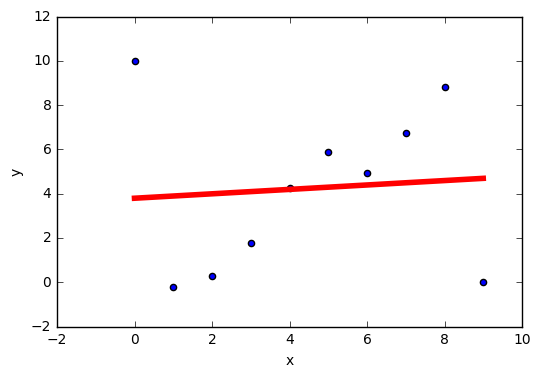

In [12]:
model = SGDRegressor(loss='squared_loss', eta0=0.01, n_iter=10000)
model.fit(x, y)
predictions = model.predict(x)
plot(x, y, predictions=predictions)

**Challenge**: Why does the regression look so unacurate?

**Answer**:

Now, in the below box, you create your own regresion to make reasonable predictions with this dataset.

In [13]:
# Write your code here and assign a value to predictions.
predictions = None

Plot them:

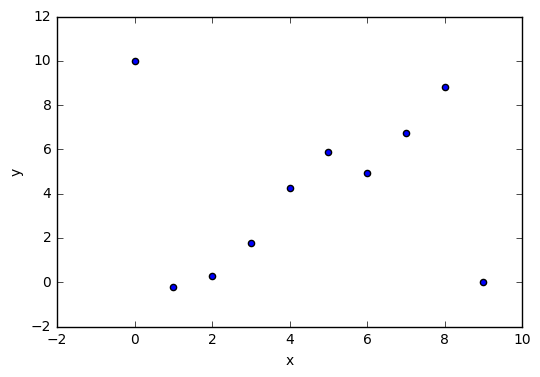

In [14]:
plot(x, y, predictions=predictions)

## Quadratic data

The following dataset has quadratic data:

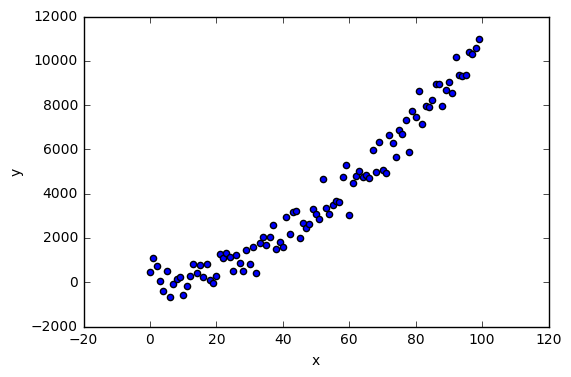

In [15]:
x, y = generate_quadratic_data(a=1, b=10, c=1, noise_std=500)
plot(x, y)

Now, make predictions using SGDRegressor:

In [16]:
# Write your code here and assign a value to predictions.
predictions = None

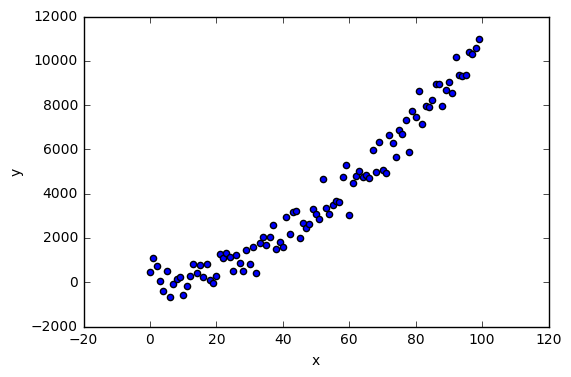

In [17]:
plot(x, y, predictions=predictions)